# 制作一个RAG应用-2

[build a RAG application | part 2](https://python.langchain.com/docs/tutorials/qa_chat_history/)

本节重点关注将历史信息纳入logic。这就涉及到历史信息的管理。

在此介绍两种方法：<br>
- Chains：设计了一个可预测的应用，这个应用对用户的每次输入最多生成一次查询。即流程严格按照Chains走
- Agents，设计了一个应用（相比Chains方法要更不可预测一些），可以进行迭代查询。（仍然使用 `create_react_agent` 方法）

本节使用 `@tool` 装饰器将自制函数封装成工具使用。

## Setup

In [1]:
import os
from langchain.chat_models import init_chat_model

os.environ.get('GOOGLE_API_KEY')
os.environ['HTTP_PROXY'] = 'http://127.0.0.1:7890'
os.environ['HTTPS_PROXY'] = 'http://127.0.0.1:7890'

llm = init_chat_model('gemini-2.5-flash', model_provider='google-genai')

In [2]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings

embeddings = GoogleGenerativeAIEmbeddings(model='models/gemini-embedding-001')

In [3]:
from langchain_chroma import Chroma

vector_store = Chroma(
    collection_name='example_collection',
    embedding_function=embeddings,
    persist_directory='./chroma_langchain_db',
)

## Chain

In [5]:
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from typing_extensions import List, TypedDict

# load and chunk contenes of the blog
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/", ),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(class_=('post-content', 'post-title', 'post-header'))
    )
)
docs = loader.load()
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

# index chunks
_ = vector_store.add_documents(documents=all_splits)

对话经历可以用 a sequence of messages 表示，其中不仅包含用户和AI的messages，还有检索到的文档以及其它可以通过`tool messages`整合到 message sequence 的工具。

也就是说，我们有：
- 用户输入 --> `HumanMessage`
- Vector store query --> `AIMessage` with tool calls
- retieved documents --> `ToolMessage`
- final response --> `AIMessage`

这种模式用途广泛，因此langgraph提供了内置版本以便使用: `MessagesState`

In [6]:
from langgraph.graph import MessagesState, StateGraph

graph_builder = StateGraph(MessagesState)

在langchain中，`tool-calling`把LLM从“纯聊天机器人”升级为“能调用外部函数的智能体”。
在part1的部分，我们增加了一个`query analysis`流程，使得模型能够对用户输入进行重写，得到更加高效的查询问句。<br>
而在`tool-calling`中，还支持模型对于无需检索的用户输入直接给出回应（而无需进行检索等步骤）<br>

为此，需要把retrieve step封装为一个`tool`


`@tool` 是一个工具装饰器，能够把自定义函数封装成 tool （前面使用的 `TvilySearch` 则是langchain封装好的工具）<br>
`response_format='content_and_artifact'` 指工具（函数）不仅返回内容，还返回工具得到的一些副产品。其中前者是交给 LLM 的， 而后者则留下来供下游（或开发者）使用

[有关tools制作的更多细节](https://python.langchain.com/docs/how_to/custom_tools/)

In [20]:
from langchain_core.tools import tool

@tool(response_format='content_and_artifact')
def retrieve(query: str):
    """retrieve information related to a query"""
    retrieved_docs = vector_store.similarity_search(query, k=2)  # 取前2个最相似的文档
    serialized = '\n\n'.join(
        (f'Source: {doc.metadata}\nContent: {doc.page_content}') for doc in retrieved_docs
    )
    return serialized, retrieved_docs


**Nodes**<br>
1. 用于提取用户输入，生成query或直接回应
2. 用于检索步骤的retriever tool
3. 用retrieved context生成最后回应

`ToolNode`：执行工具，并把结果作为 `TooMessage` 添加到state中

In [ ]:
from langchain_core.messages import SystemMessage
from langgraph.prebuilt import ToolNode

# step1: 生成一条AIMessage，其中可能包含一个工具调用
def query_or_respond(state: MessagesState):
    """generate tool call for retrieval or respond"""
    llm_with_tools = llm.bind_tools([retrieve])
    response = llm_with_tools.invoke(state['messages'])
    # MessagesState append messages to state instead of overwriting
    return {"messages": [response]}

# step2: execte the retrieval
tools = ToolNode([retrieve])

# step3: generate a response using the retrieved content
def generate(state: MessagesState):
    """generate answer"""
    # get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state['messages']):
        if message.type == 'tool':
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # fomat into prompt
    docs_content = '\n\n'.join(doc.content for doc in tool_messages)
    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know. Use three sentences maximum and keep the "
        "answer concise."
        "\n\n"
        f"{docs_content}"
    )
    conversation_messages = [  # 对话信息包含：human, system, 和不带tool_calls的aimessage
        message
        for message in state["messages"]
        if message.type in ('human', 'system')
        or (message.type == 'ai' and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    response = llm.invoke(prompt)
    return {'messages': [response]}

**编译**<br>
把应用编译为一个`graph`对象

`tools_condition`：条件函数。用于检查来源节点`query_or_respond`输出的最新 `AIMessage` 是否包含 `tool_calls`：
- 如果不包含，则返回路由键 `END` ，那么图直接结束；
- 否则，返回路由键 `tools`，图跳转到工具执行节点

In [9]:
from langgraph.graph import END
from langgraph.prebuilt import ToolNode, tools_condition

graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point('query_or_respond')
graph_builder.add_conditional_edges(
    'query_or_respond',
    tools_condition,
    {END: END, 'tools': 'tools'}
)
graph_builder.add_edge('tools', 'generate')
graph_builder.add_edge('generate', END)

graph = graph_builder.compile()

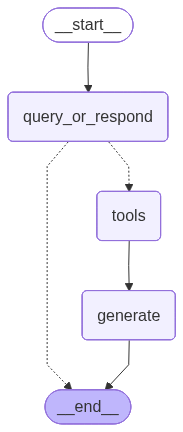

In [10]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [12]:
for step in graph.stream(
    {'messages': [{'role': 'user', 'content': 'Hi!'}]},
    stream_mode='values'
):
    step['messages'][-1].pretty_print()

================================ Human Message =================================

Hi!
================================== Ai Message ==================================

Hello! How can I help you today?


In [13]:
input_message = "what's task decomposition?"
for step in graph.stream(
    {'messages': [{'role': 'user', 'content': input_message}]},
    stream_mode='values'
):
    step['messages'][-1].pretty_print()

================================ Human Message =================================

what's task decomposition?
================================== Ai Message ==================================
Tool Calls:
  retrieve (e1817007-b11b-4e7f-af1a-c12cb8666104)
 Call ID: e1817007-b11b-4e7f-af1a-c12cb8666104
  Args:
    query: task decomposition
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.
Another quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL) as an intermediate int

### Staeful management of chat history
两种常用的方法：
- `RunnableWithMessageHistory` : 在简单的对话应用场景中非常适用
- `LangGraph` ： 内置了一个 `persistence layer` ，使得支持多轮对话

这里我们使用 `LangGraph` 方法用于管理多个对话回合和线程。为此，我们需要在编译应用是指定一个 `checkpointer` 

In [15]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

config = {"configurable": {"thread_id": 'abc123'}}

In [16]:
def ask(input_message):
    for step in graph.stream(
        {"messages": [{'role': 'user', 'content': input_message}]},
        stream_mode='values',
        config=config
    ):
        step['messages'][-1].pretty_print()

ask(input_message = "what's task decomposition?")

================================ Human Message =================================

what's task decomposition?
================================== Ai Message ==================================
Tool Calls:
  retrieve (e3ddb37d-a937-475a-bf8e-7f5c4aabdc23)
 Call ID: e3ddb37d-a937-475a-bf8e-7f5c4aabdc23
  Args:
    query: task decomposition
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.
Another quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL) as an intermediate int

In [17]:
ask(input_message = "Can you look up some common ways of doing it?")

================================ Human Message =================================

Can you look up some common ways of doing it?
================================== Ai Message ==================================

Task decomposition can be achieved through several common methods:

1.  **Using an LLM with simple prompting:** This involves giving the LLM prompts like "Steps for XYZ" or "What are the subgoals for achieving XYZ?" to break down a task.
2.  **Using task-specific instructions:** This approach utilizes pre-defined instructions tailored to a specific task, for example, "Write a story outline" when the overall task is to write a novel.
3.  **Human inputs:** Direct human guidance and input can also be used to decompose tasks.

Additionally, a more distinct approach called LLM+P (Liu et al. 2023) involves using an external classical planner for long-horizon planning. This method translates the problem into "Problem PDDL" (Planning Domain Definition Language), uses a classical planner 

## Agent

agent 和 上面的的方法的关键区别在于：工具调用之后会循环回到原始的 LLM 调用。模型可以自行决定使用检索文本回答问题，或是生成另一个 tool call 来获得更多的信息

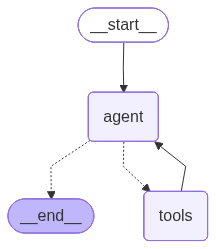

In [18]:
from langgraph.prebuilt import create_react_agent

agent_executor = create_react_agent(llm, [retrieve], checkpointer=memory)
display(Image(agent_executor.get_graph().draw_mermaid_png()))

In [19]:
config = {"configurable": {"thread_id": "def234"}}

input_message = (
    "What is the standard method for Task Decomposition?\n\n"
    "Once you get the answer, look up common extensions of that method."
)

for event in agent_executor.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is the standard method for Task Decomposition?

Once you get the answer, look up common extensions of that method.
================================== Ai Message ==================================
Tool Calls:
  retrieve (02c25bcc-dbe8-44ad-9396-26481d328ecd)
 Call ID: 02c25bcc-dbe8-44ad-9396-26481d328ecd
  Args:
    query: standard method for Task Decomposition
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.
Another quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do lo